## Loader加载器
***
- 如何加载PDF
- 使用多模态解析图文PDF
- 如何加载网页
- 如何加载CSV以及Excel
- 如何自定义一个文件加载器

#### 如何加载PDF
*****

In [1]:
! pip install langchain_community


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
! pip install pypdf


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
file_path='deepseek.pdf'

In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 21 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)


In [5]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'iOS Version 16.7.10 (Build 20H350) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20250208000307Z00'00'", 'moddate': '2025-02-08T08:06:48+08:00', 'source': 'deepseek.pdf', 'total_pages': 7, 'page': 0, 'page_label': '1'}

《Deepseek R1 本地部署完全⼿册》
版权归：HomeBrew Ai Club          
作者wechat：samirtan
版本：V2.0          
更新⽇期：2025年2⽉8⽇
⼀、简介
Deepseek R1 是⽀持复杂推理、多模态处理、技术⽂档⽣成的⾼性能通⽤⼤语⾔模型。本⼿册
为技术团队提供完整的本地部署指南，涵盖硬件配置、国产芯⽚适配、量化⽅案、云端替代⽅
案及完整671B MoE模型的Ollama部署⽅法。
核⼼提示：
个⼈⽤户：不建议部署32B及以上模型，硬件成本极⾼且运维复杂。
企业⽤户：需专业团队⽀持，部署前需评估ROI（投资回报率）。
⼆、本地部署核⼼配置要求
1. 模型参数与硬件对应表
模型参
数 Windows 配置要求 Mac 配置要求 适⽤场景
1.5B
- RAM: 4GB
- GPU: 集成显卡/现代CPU
- 存储: 5GB
- 内存: 8GB
（M1/M2/M3）
- 存储: 5GB
简单⽂本⽣成、基础代
码补全
7B
- RAM: 8-10GB
- GPU: GTX 1680（4-bit量
化）
- 存储: 8GB
- 内存: 16GB（M2
Pro/M3）
- 存储: 8GB
中等复杂度问答、代码
调试
14B
- RAM: 24GB
- GPU: RTX 3090（24GB
VRAM）
- 存储: 20GB
- 内存: 32GB（M3
Max）
- 存储: 20GB
复杂推理、技术⽂档⽣
成
32B+ 企业级部署（需多卡并联）暂不⽀持 科研计算、⼤规模数据
处理


### 多模态模型解析PDF
****
对于包含图片内容的PDF可以使用多模态或unstructured解析

In [6]:
file_path='z2021.pdf'

In [7]:
! pip install -qU PyMuPDF pillow langchain-openai IPython


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

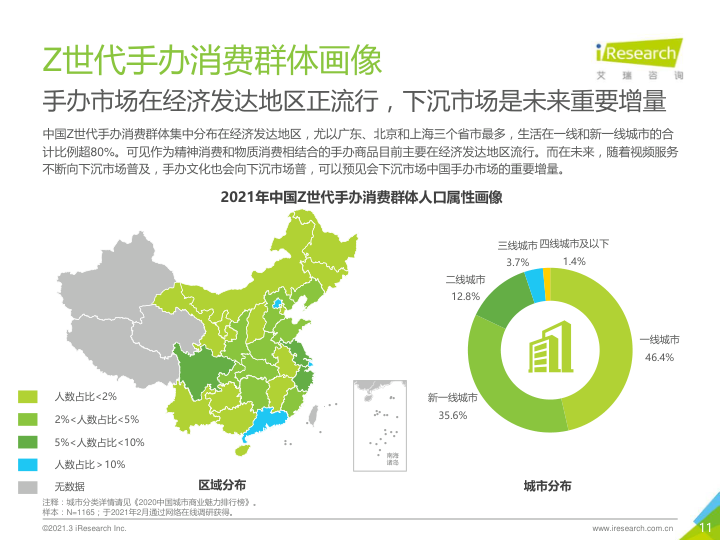

In [8]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

使用多模态

In [10]:
from langchain_openai import ChatOpenAI
import os
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
    )

In [11]:
from langchain_core.messages import HumanMessage

query = "一线城市消费者占比有多少？"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

根据图表，一线城市消费者占比为46.4%。


### 解析网页
***

In [19]:
! pip install -qU langchain-community beautifulsoup4 unstructured


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
! pip install -qU langchain-unstructured


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"

loader = WebBaseLoader(web_paths=[page_url])
docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

assert len(docs) == 1
doc = docs[0]

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.25it/s]


In [13]:
print(f"{doc.metadata}\n")
print(doc.page_content[:500].strip())

{'source': 'https://python.langchain.com/docs/how_to/chatbots_memory/', 'title': 'How to add memory to chatbots | 🦜️🔗 LangChain', 'description': 'A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:', 'language': 'en'}

How to add memory to chatbots | 🦜️🔗 LangChain






Skip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented


制定加载网页某一部分

In [14]:
loader = WebBaseLoader(
    web_paths=[page_url],
    bs_kwargs={
        "parse_only": bs4.SoupStrainer(class_="theme-doc-markdown markdown"),
    },
    bs_get_text_kwargs={"separator": " | ", "strip": True},
)

docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

assert len(docs) == 1
doc = docs[0]

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


In [15]:
print(f"{doc.metadata}\n")
print(doc.page_content[:500])

{'source': 'https://python.langchain.com/docs/how_to/chatbots_memory/'}

How to add memory to chatbots | A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including: | Simply stuffing previous messages into a chat model prompt. | The above, but trimming old messages to reduce the amount of distracting information the model has to deal with. | More complex modifications like synthesizing summaries for long running conversations. | We'll go into more detail on a few t


高级：不熟悉网页结构的情况下解析网页

In [16]:
from langchain_unstructured import UnstructuredLoader

page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"
loader = UnstructuredLoader(web_url=page_url)

docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

In [17]:
for doc in docs[:5]:
    print(doc.page_content)

How to add memory to chatbots
A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:
Simply stuffing previous messages into a chat model prompt.
The above, but trimming old messages to reduce the amount of distracting information the model has to deal with.
More complex modifications like synthesizing summaries for long running conversations.


### 加载CVS
***

In [18]:
from langchain_community.document_loaders.csv_loader import CSVLoader

file_path = "PMBOK6.csv"

loader = CSVLoader(file_path=file_path)
data = loader.load()

for record in data[:2]:
    print(record)

page_content='名称: 专家判断
内容: 是指基于某应用领域、知识领域、学科和行业等的专业知识而做出的，关于当前活动的
合理判断，这些专业知识可来自具有专业学历、知识、技能、经验或培训经历的任何小组或个人。
◆组织战略；
◆ 效益管理；
◆ 关于项目所在的行业以及项目关注的领域的技术知识；
◆ 持续时间和预算的估算；
◆ 风险识别。
章节部位: 4.1.1.1
知识域: 项目整合管理
过程: 制定项目章程' metadata={'source': 'PMBOK6.csv', 'row': 0}
page_content='名称: 头脑风暴
内容: 本技术用于在短时间内获得大量创意，适用于团队环境，需要引导者进行引导。
头脑风暴由两个部分构成：创意产生和创意分析。制定项目章程时可通过头脑风暴向相关方、主题专家和团队成员收集数据、解决方案或创意。
章节部位: 4.1.1.1
知识域: 项目整合管理
过程: 制定项目章程' metadata={'source': 'PMBOK6.csv', 'row': 1}


指定一列来标识文档

In [19]:
loader = CSVLoader(file_path=file_path, source_column="名称")

data = loader.load()
for record in data[:2]:
    print(record)

page_content='名称: 专家判断
内容: 是指基于某应用领域、知识领域、学科和行业等的专业知识而做出的，关于当前活动的
合理判断，这些专业知识可来自具有专业学历、知识、技能、经验或培训经历的任何小组或个人。
◆组织战略；
◆ 效益管理；
◆ 关于项目所在的行业以及项目关注的领域的技术知识；
◆ 持续时间和预算的估算；
◆ 风险识别。
章节部位: 4.1.1.1
知识域: 项目整合管理
过程: 制定项目章程' metadata={'source': '专家判断', 'row': 0}
page_content='名称: 头脑风暴
内容: 本技术用于在短时间内获得大量创意，适用于团队环境，需要引导者进行引导。
头脑风暴由两个部分构成：创意产生和创意分析。制定项目章程时可通过头脑风暴向相关方、主题专家和团队成员收集数据、解决方案或创意。
章节部位: 4.1.1.1
知识域: 项目整合管理
过程: 制定项目章程' metadata={'source': '头脑风暴', 'row': 1}


### 解析excel
****
使用微软云的Document intelligence服务来解析，需要申请KEY

In [25]:
! pip install --upgrade --quiet  langchain langchain-community azure-ai-documentintelligence


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [20]:
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

file_path = "PMBOK62.xlsx"
endpoint ="https://jiaoxue.cognitiveservices.azure.com/"
key = "FdsAwGHwsQhEKkEYUN1OaBvR4a5f8GXJqPMPMYTAM70lABs1QgSHJQQJ99BCAC8vTInXJ3w3AAALACOGTQvM"
loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=endpoint, api_key=key, file_path=file_path, api_model="prebuilt-layout"
)

documents = loader.load()

INFO: Request URL: 'https://jiaoxue.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-layout:analyze?api-version=REDACTED&outputContentFormat=REDACTED'
Request method: 'POST'
Request headers:
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'f9e63582-0007-11f0-b04a-ee76092d5572'
    'x-ms-useragent': 'REDACTED'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.0 Python/3.13.2 (macOS-15.3.1-arm64-arm-64bit-Mach-O)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request
INFO: Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Thu, 13 Mar 2025 12:37:56 GMT'
INFO: Request URL: 'https://jiaoxue.cognitiveservices.azure.co

#### 自定义文档加载器
*****


一个文档加载器包含的主要方法

![](loader.png)

In [34]:
! pip install aiofiles

  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from typing import AsyncIterator, Iterator

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document


class CustomDocumentLoader(BaseLoader):
    """逐行读取文件的文档加载器示例"""

    def __init__(self, file_path: str) -> None:
        """使用文件路径初始化加载器

        参数:
            file_path: 要加载的文件路径
        """
        self.file_path = file_path

    def lazy_load(self) -> Iterator[Document]:  # <-- 不接受任何参数
        """逐行读取文件的惰性加载器

        当实现惰性加载方法时,你应该使用生成器
        一次生成一个文档
        """
        with open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1

    # alazy_load 是可选的
    # 如果不实现它,将使用一个默认实现,该实现会委托给 lazy_load!
    async def alazy_load(
        self,
    ) -> AsyncIterator[Document]:  # <-- 不接受任何参数
        """逐行读取文件的异步惰性加载器"""
        # 需要 aiofiles (通过 pip 安装)
        # https://github.com/Tinche/aiofiles
        import aiofiles

        async with aiofiles.open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            async for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1


测试

In [22]:
with open("meow.txt", "w", encoding="utf-8") as f:
    quality_content = "meow meow🐱 \n meow meow🐱 \n meow😻😻"
    f.write(quality_content)

loader = CustomDocumentLoader("meow.txt")

In [23]:
## 测试懒加载
for doc in loader.lazy_load():
    print()
    print(type(doc))
    print(doc)


<class 'langchain_core.documents.base.Document'>
page_content='meow meow🐱 
' metadata={'line_number': 0, 'source': 'meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 
' metadata={'line_number': 1, 'source': 'meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow😻😻' metadata={'line_number': 2, 'source': 'meow.txt'}
